# Imports and settings

In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:

env = gym.make('CartPole-v1')
seed = 0
env.reset(seed=seed)

(array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32),
 {})

In [5]:
from utils.classes import Policy

import utils.classes
torch.serialization.add_safe_globals([getattr, torch.nn.modules.linear.Linear, utils.classes.Policy])


# Testing baselines for REINFORCE

In [6]:
from utils.baselines import naive_baseline, baseline_1, baseline_2

from utils.reinforce import reinforce_rwd2go, reinforce_rwd2go_baseline

In [7]:
np.bool8 = bool
run=False

if run:
    # naive baseline
    policy_naive_baseline = Policy().to(device)
    optimizer_naive_baseline = optim.Adam(policy_naive_baseline.parameters(), lr=1e-2)
    scores_naive_baseline = reinforce_rwd2go_baseline(policy_naive_baseline, optimizer_naive_baseline, seed=seed, baseline=naive_baseline, env=env, early_stop=True, n_episodes=200)

    env = gym.make('CartPole-v0')


    # baseline 1
    policy_baseline_1 = Policy().to(device)
    optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
    scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, seed=seed, baseline=baseline_1, env=env, early_stop=True, n_episodes=200)

    env = gym.make('CartPole-v0')

    # baseline 2
    policy_baseline_2 = Policy().to(device)
    optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
    scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, seed=seed, baseline=baseline_2, env=env, early_stop=True, n_episodes=200)


In [8]:
if run:    
### Plot the learning progress

    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    #ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
    ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
    ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')
    ax.plot(np.arange(1, len(scores_naive_baseline) + 1), scores_naive_baseline, color='black', label='Naive Baseline')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

# Generating the preference dataset

In [9]:
from utils.generate_preference_dataset import generate_trajectories


In [10]:
# Policy saving
run=False
if run:

    np.bool8 = bool
    seed = 0
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    target_score = 500
    n_episodes = 500
    print_every = 500
    max_t = 1000
    baseline = naive_baseline

    example_policy = Policy().to(device)
    optimizer_baseline_1 = optim.Adam(example_policy.parameters(), lr=1e-2)
    example_scores = reinforce_rwd2go_baseline(example_policy, optimizer_baseline_1, seed=seed, env=env, target_score=target_score, baseline=baseline, early_stop=False, n_episodes=n_episodes, max_t=max_t, print_every=print_every, save_models_every=False)

## Loading policies (manual intervention required)

Rename the policies you want to choose as $\pi_1$ and $\pi_2$

In [11]:
PATH = os.path.abspath(os.getcwd())

# TO COMPLETE, choose the file names of the desired policies

pi1_path = os.path.join(PATH, 'saved_policies', 'pi1_cartpole_0.pt')

pi2_path = os.path.join(PATH, 'saved_policies', 'pi2_cartpole_0.pt')

In [12]:
# Compare on K trajectories
run=False
if run:

    seeds = [0,1,2]
    n_trajectories = 500
    max_t=1000
    rewards_for_all_seeds_pi1 = np.zeros((n_trajectories, len(seeds)))
    rewards_for_all_seeds_pi2 = np.zeros((n_trajectories, len(seeds)))

    for seed_index, seed in enumerate(seeds):
        pi1 = Policy().to(device)
        pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

        env = gym.make('CartPole-v1')
        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, n_trajectories, env=env, max_t=max_t, seed = seed, dim_state=4)

        rewards_for_all_seeds_pi1[:,seed_index] = trajectories_rewards_pi1[:]

        pi2 = Policy().to(device)
        pi2.load_state_dict(torch.load(pi2_path, weights_only=True))

        env = gym.make('CartPole-v1')
        trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, n_trajectories, env=env, max_t=max_t, seed = seed, dim_state=4)

        rewards_for_all_seeds_pi2[:,seed_index] = trajectories_rewards_pi2[:]

    rewards_avg_seeds_pi1 = np.mean(rewards_for_all_seeds_pi1, axis=1)
    rewards_avg_seeds_pi2 = np.mean(rewards_for_all_seeds_pi2, axis=1)



## Making sure $\pi_1$ performs $\sim$ twice as good as $\pi_2$:

In [13]:
run=False
if run:
    avg_pi1 = np.mean(rewards_avg_seeds_pi1)
    avg_pi2 = np.mean(rewards_avg_seeds_pi2)
    print(avg_pi1, avg_pi2)

In [14]:
run=False
if run:
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    #ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
    ax.plot(np.arange(1, n_trajectories + 1), rewards_avg_seeds_pi1, color='blue', label='Trajectories generated from pi_1')
    ax.plot(np.arange(1, n_trajectories + 1), rewards_avg_seeds_pi2, color='red', label='Trajectories generated from pi_2')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward, \n averaged on 3 seeds', fontsize=20)
    ax.set_xlabel('Trajectory #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

## Preference dataset

The goal is to get a set $\left\{(s_i, a_i^+, a_i^-) \in \mathcal{S}\times \mathcal{A}\times \mathcal{A} \; | \; 0\leq i \leq K   \right\}$

### State sampling method 1:

Run trajectories with $\pi_1$ and $\pi_2$, and complete with the rejected or preferred action remaining

In [15]:
from utils.generate_preference_dataset import generate_preference_dataset
dataset_size = 1000
seed=0
env = gym.make('CartPole-v1')
env.reset(seed=seed)
print_every = 10
max_t = 999
sampling_method='pi1_pi2_trajectories'

pi1_path = os.path.join(PATH, 'saved_policies', 'pi1_cartpole_0.pt')
pi1 = Policy().to(device)
pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

pi2_path = os.path.join(PATH, 'saved_policies', 'pi2_cartpole_0.pt')
pi2 = Policy().to(device)
pi2.load_state_dict(torch.load(pi2_path, weights_only=True))

states, preferred_actions, rejected_actions = generate_preference_dataset(pi1, pi2, dataset_size=dataset_size, env=env, max_t=max_t, seed=seed, dim_state=4, print_every=print_every, sampling_method=sampling_method)


 First half 


 Second half 



In [16]:
print(states.shape)
print(max(states[:,2]))

(1000, 4)
0.0


### Uniform / normal sampling

The coordinates of the states $s_i$ are either sampled from a uniform distribution (for the positions) or from a standard normal distribution (for the velocities)

In [17]:
dataset_size = 1000
seed=0
env = gym.make('CartPole-v1')
env.reset(seed=seed)
max_t = 999
sampling_method='uniform_cartpole'

pi1_path = os.path.join(PATH, 'saved_policies', 'pi1_cartpole_0.pt')
pi1 = Policy().to(device)
pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

pi2_path = os.path.join(PATH, 'saved_policies', 'pi2_cartpole_0.pt')
pi2 = Policy().to(device)
pi2.load_state_dict(torch.load(pi2_path, weights_only=True))

states_uniform, preferred_actions_uniform, rejected_actions_uniform = generate_preference_dataset(pi1, pi2, dataset_size=dataset_size, env=env, max_t=max_t, seed=seed, dim_state=4, print_every=print_every, sampling_method=sampling_method)

In [18]:
print(states_uniform.shape)

(1000, 4)


# Learning the reward function

In [19]:
from utils.classes import Reward
from tqdm import tqdm

In [20]:
SEEDS = [42, 123, 456]
TOTAL_TIMESTEPS = 50000
ENV_NAME = ['CartPole-v1', 'MountainCar-v0']
EVAL_N_EPISODES = 5
EVAL_LEARNING_RATE = 0.005



In [23]:
reward_model = Reward(dim_state=4, dim_action=1).to(device)
optimizer = optim.Adam(reward_model.parameters(), lr=1e-5)
n_epochs = 10


losses = []
for epoch in tqdm(range(n_epochs)):
    # Calculate the loss
    reward_loss = []
    for i in range(dataset_size):
        state = states[i]
        pref_action = preferred_actions[i]
        rej_action = rejected_actions[i]
        # Convert states to tensors
        state = torch.tensor(state, dtype=torch.float).to(device)
        pref_action = torch.tensor(pref_action, dtype=torch.float).to(device)
        rej_action = torch.tensor(rej_action, dtype=torch.float).to(device)
				
		# Get the reward for each action
        rewards_pref = reward_model(state, pref_action)
        rewards_rej = reward_model(state, rej_action)
        with torch.no_grad():
            print('r+,r-: ', rewards_pref, rewards_rej)
			
		# Calculate reward loss
        loss = - torch.log(torch.sigmoid(rewards_pref - rewards_rej))
           # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
        reward_loss.append(loss)
        # After that, we concatenate whole policy loss in 0th dimension
    reward_loss = torch.cat(reward_loss).sum()
    with torch.no_grad():
        losses.append(reward_loss.item())
    # Backpropagation
    optimizer.zero_grad()
    reward_loss.backward()
    for param in reward_model.parameters():
        print(param.grad.max())  # Check for non-zero gradients
    optimizer.step()


  0%|          | 0/10 [00:00<?, ?it/s]

r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBack

 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 20%|██        | 2/10 [00:01<00:07,  1.01it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 40%|████      | 4/10 [00:03<00:05,  1.12it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 50%|█████     | 5/10 [00:04<00:04,  1.13it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 60%|██████    | 6/10 [00:05<00:03,  1.14it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 70%|███████   | 7/10 [00:06<00:02,  1.16it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 80%|████████  | 8/10 [00:07<00:01,  1.17it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

 90%|█████████ | 9/10 [00:07<00:00,  1.19it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  tensor([0.], grad_fn=<ReluBackward0>) tensor([0.], grad_fn=<ReluBackward0>)
r+,r-:  te

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


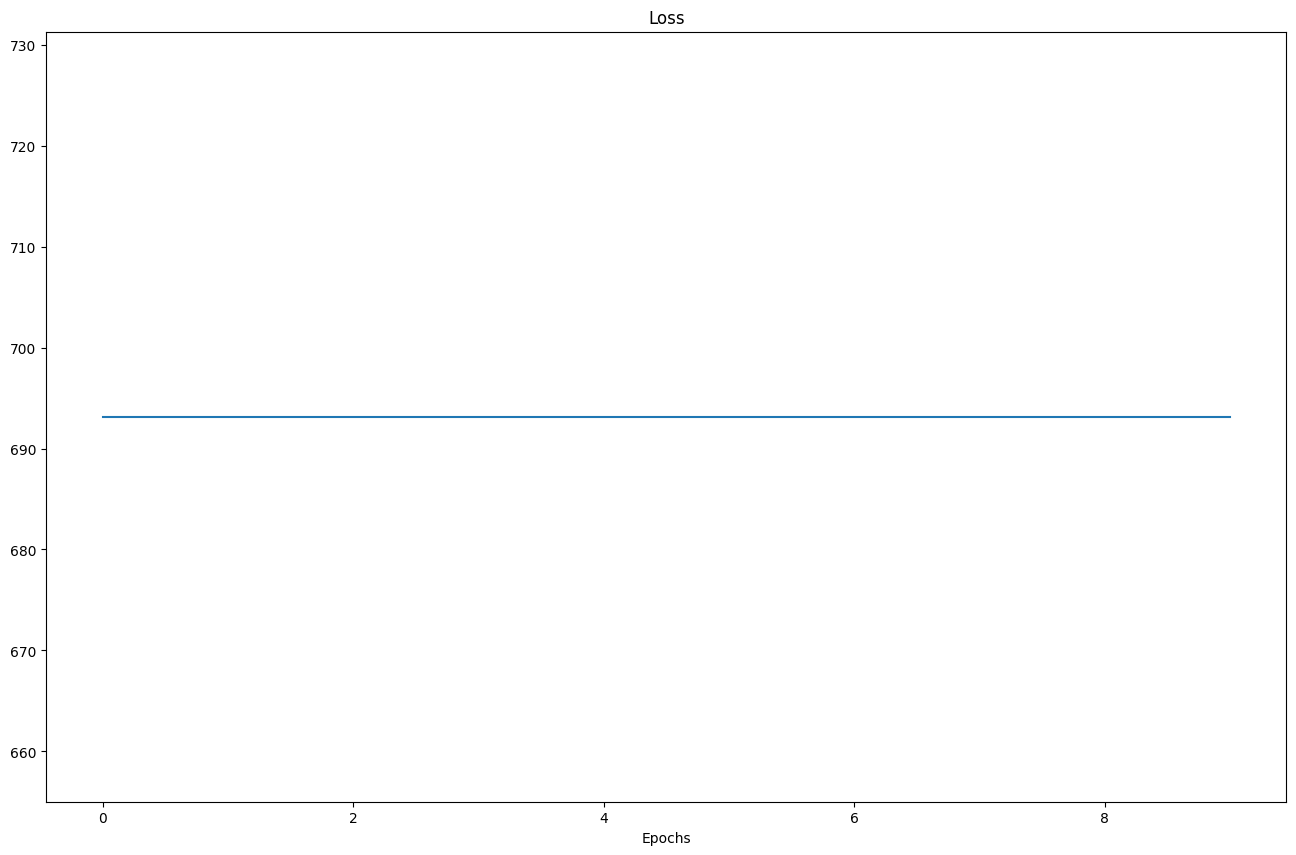

In [22]:
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()